# Use CMGF for One-Pass MLP Classifier Training

Author: Peter Chang([@petergchang](https://github.com/petergchang))

Video of training: https://gist.github.com/petergchang/9441b853b889e0b47d0622da8f7fe2f6


# Imports and Plotting Functions

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax
print(dynamax.__file__)

from dynamax.cond_moments_gaussian_filter.cmgf import *

In [4]:
try:
    import flax.linen as nn
except ModuleNotFoundError:
    print('installing flax')
    %pip install -qq flax
import flax.linen as nn

In [5]:
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree

In [6]:
# Helper function that visualizes 2d posterior predictive distribution
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    return ax

# Create data

First, we generate a binary spiral data.

In [7]:
# Generate spiral dataset
# Adapted from https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
def generate_spiral_dataset(key=0, num_per_class=250, zero_var=1., one_var=1., shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, key3, key4 = jr.split(key, 4)

    theta = jnp.sqrt(jr.uniform(key1, shape=(num_per_class,))) * 2*jnp.pi
    r = 2*theta + jnp.pi
    generate_data = lambda theta, r: jnp.array([jnp.cos(theta)*r, jnp.sin(theta)*r]).T

    # Data for output zero
    zero_input = generate_data(theta, r) + zero_var * jr.normal(key2, shape=(num_per_class, 2))
    zero_output = jnp.zeros((num_per_class, 1,))

    # Data for output one
    one_input = generate_data(theta, -r) + one_var * jr.normal(key3, shape=(num_per_class, 2))
    one_output = jnp.ones((num_per_class, 1,))

    # Stack the inputs and standardize
    input = jnp.concatenate([zero_input, one_input])
    input = (input - input.mean(axis=0)) / input.std(axis=0)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros(num_per_class), jnp.ones(num_per_class)])

    if shuffle:
        idx = jr.permutation(key4, jnp.arange(num_per_class * 2))
        input, output = input[idx], output[idx]

    return input, output

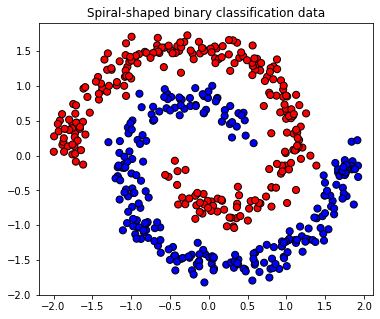

In [8]:
# Generate data
input, output = generate_spiral_dataset()

# Plot data
fig, ax = plt.subplots(figsize=(6, 5))

title = "Spiral-shaped binary classification data"
plot_posterior_predictive(ax, input, output, title);

# Plotting code

Next, let us define a grid on which we compute the predictive distribution.

In [9]:
# Define grid limits
xmin, ymin = input.min(axis=0) - 0.1
xmax, ymax = input.max(axis=0) + 0.1

# Define grid
step = 0.1
x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

Next, we define a function to that returns the posterior predictive probability for each point in grid.

In [10]:
# 'binary=True' indicates rounding probabilities to binary outputs
def posterior_predictive_grid(grid, mean, apply, binary=False):
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

# Model

Finally, we define a generic MLP class that uses a sigmoid activation function.

In [11]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [12]:
def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

# Online Training Using CMGF-EKF

In [13]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [15, 15], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)

In [14]:
# Some model parameters and helper funciton
state_dim, emission_dim = flat_params.size, output_dim
sigmoid_fn = lambda w, x: jax.nn.sigmoid(apply_fn(w, x))

# Run CMGF-EKF to train the MLP Classifier
cmgf_ekf_params = EKFParams(
    initial_mean=flat_params,
    initial_covariance=jnp.eye(state_dim),
    dynamics_function=lambda w, x: w,
    dynamics_covariance=jnp.eye(state_dim) * 1e-4,
    emission_mean_function = lambda w, x: sigmoid_fn(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
)
cmgf_ekf_post = conditional_moments_gaussian_filter(cmgf_ekf_params, output, inputs=input)

# Extract history of filtered weight values
w_means, w_covs = cmgf_ekf_post.filtered_means, cmgf_ekf_post.filtered_covariances

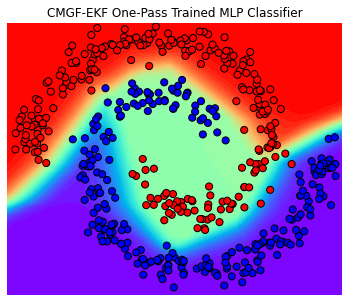

In [15]:
# Evaluate the trained MLP on input_grid
Z = posterior_predictive_grid(input_grid, w_means[-1], sigmoid_fn, binary=False)

# Plot the final result
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, input, output, title, input_grid, Z);

Next, we visualize the training procedure by evaluating the intermediate steps.

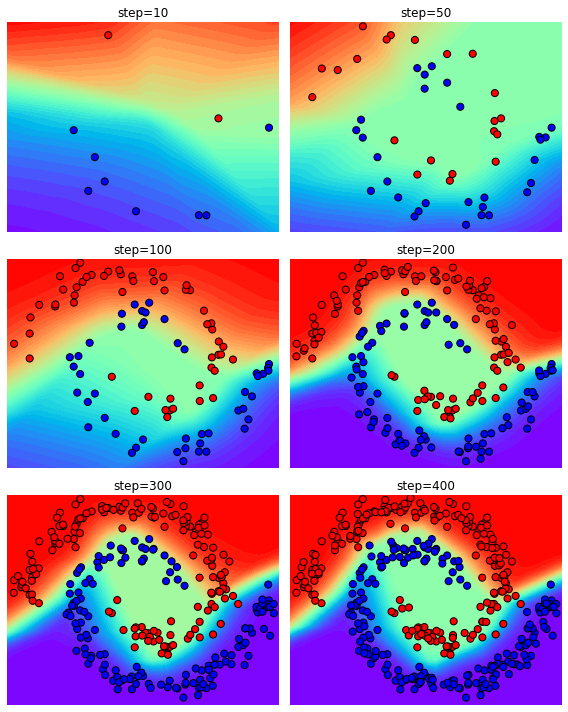

In [16]:
intermediate_steps = [9, 49, 99, 199, 299, 399]
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid, w_means[step], sigmoid_fn)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, input[:step+1], output[:step+1], title, input_grid, Zi)
plt.tight_layout()

Finally, we generate a video of the MLP-Classifier being trained.

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML

In [18]:
def animate(i):
    ax.cla()
    w_curr = w_means[i]
    Zi = posterior_predictive_grid(input_grid, w_means[i], sigmoid_fn)
    title = f'CMGF-EKF-MLP ({i+1}/500)'
    plot_posterior_predictive(ax, input[:i+1], output[:i+1], title, input_grid, Zi)
    
    return ax

dyld[32198]: Library not loaded: '@rpath/libopenh264.5.dylib'
  Referenced from: '/opt/anaconda3/lib/libavcodec.58.91.100.dylib'
  Reason: tried: '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/bin/../lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/lib/libopenh264.5.dylib' (no such file), '/opt/anaconda3/bin/../lib/libopenh264.5.dylib' (no such file), '/usr/local/lib/libopenh264.5.dylib' (no such file), '/usr/lib/libopenh264.5.dylib' (no such file)



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x1000', '-pix_fmt', 'rgba', '-r', '24', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'cmgf_mlp_classifier.mp4']' died with <Signals.SIGABRT: 6>.

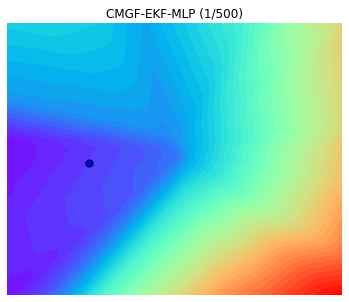

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, animate, frames=500, interval=50)
anim.save("cmgf_mlp_classifier.mp4", dpi=200, bitrate=-1, fps=24)

In [31]:
HTML(anim.to_html5_video())